# Model Selection Notebook

**Objective:** Compare FNN, RNN and Transformer on FPL player‐sequence data, tune key hyperparameters, visualize training, and select the best model for evaluation


### Getting the Data

We use the `make_dataset.py` script to transform processed data into a model-ready format. This includes:

- Dropping the necessary columns
- Creating time sequences
- Handling missing values
- Creating attention masks


What do we need to do:

- Splitting into training/validation/test sets
- Comparing different model architectures
- Visualizing the training and model selection
- Hyperparameter tuning


!!! Our data is both sparse and has outliers, needs to be kept in mind

In [1]:
# for corrent imports
import sys
from pathlib import Path

PROJECT_ROOT = Path().resolve().parent  
SRC_DIR       = PROJECT_ROOT / "src"
DATA_DIR      = PROJECT_ROOT / "data"

sys.path.insert(0, str(SRC_DIR))       


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import pytorch_lightning as pl
import math
from torch.utils.data import DataLoader

from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
from torch.optim.lr_scheduler import SequentialLR, LinearLR, CosineAnnealingLR, MultiStepLR

from sklearn.preprocessing import StandardScaler, MaxAbsScaler 
import os
import seaborn as sns

from data.make_dataset import prepare_player_sequences, FPLPlayerSequenceDataset

In [3]:
# generate sequences
# work on the time issue
sequences, masks, targets = prepare_player_sequences(
    df_path=str(DATA_DIR / "processed_data.csv"),
    target_col="total_points",
    max_gws_in_sequence= 38,
)



--- Starting Data Preparation for Sequences from C:\Users\asus\OneDrive\Desktop\projects\AI_project\data\processed_data.csv ---
Successfully loaded data. Shape: (28742, 84)

--- Cleaning Data and Selecting Numeric Features ---
Column 'name' is of type object and couldn't be converted to numeric. Marked for dropping.
Column 'position' is of type object and couldn't be converted to numeric. Marked for dropping.
Column 'team' is of type object and couldn't be converted to numeric. Marked for dropping.
Column 'kickoff_time' is of type object and couldn't be converted to numeric. Marked for dropping.
Note: 'player_id' is in selected features. It will be part of the dense sequence.
Column '['assists', 'bonus', 'bps', 'clean_sheets', 'creativity', 'goals_conceded', 'goals_scored', 'ict_index', 'influence', 'minutes', 'own_goals', 'penalties_missed', 'penalties_saved', 'red_cards', 'saves', 'starts', 'threat', 'yellow_cards', 'xP', 'expected_assists', 'expected_goal_involvements', 'expected_go

In [32]:
# train/val/test split
# we do it a chronological way 

n = sequences.shape[0]

train_end = int(n * 0.70)          
val_end   = train_end + int(n * 0.15)  

train_idx = np.arange(0, train_end)
val_idx   = np.arange(train_end, val_end)
test_idx  = np.arange(val_end, n)


In [33]:
scaler = MaxAbsScaler() #better for sparse data 
print("Fitting StandardScaler on training data features...")

train_sequences_reshaped = sequences[train_idx].reshape(-1, sequences.shape[2])

scaler.fit(train_sequences_reshaped)


def scale_3d_sequences(sequence_array_3d, fitted_scaler):
    if sequence_array_3d.shape[0] == 0: # Handle empty array
        return sequence_array_3d 
    
    original_shape = sequence_array_3d.shape
    num_features_in_array = original_shape[2]
    
    # Reshape to 2D: [N_samples_in_split * S_seq_len, F_features]
    reshaped_array = sequence_array_3d.reshape(-1, num_features_in_array)
    
    # Transform using the FITTED scaler
    scaled_reshaped_array = fitted_scaler.transform(reshaped_array)
    
    # Reshape back to original 3D shape
    return scaled_reshaped_array.reshape(original_shape)


print("Scaling train, val, and test sequences using the fitted scaler...")
sequences_train_scaled = scale_3d_sequences(sequences[train_idx], scaler)
sequences_val_scaled = scale_3d_sequences(sequences[val_idx], scaler)
sequences_test_scaled = scale_3d_sequences(sequences[test_idx], scaler)

Fitting StandardScaler on training data features...
Scaling train, val, and test sequences using the fitted scaler...


In [34]:
masks_train = masks[train_idx]
targets_train = targets[train_idx]

masks_val = masks[val_idx]
targets_val = targets[val_idx]

masks_test = masks[test_idx]
targets_test = targets[test_idx]


train_ds = FPLPlayerSequenceDataset(sequences_train_scaled, targets_train, masks_train) 
val_ds = FPLPlayerSequenceDataset(sequences_val_scaled, targets_val, masks_val)     
test_ds = FPLPlayerSequenceDataset(sequences_test_scaled, targets_test, masks_test)     




train_loader = DataLoader(train_ds, batch_size=128, shuffle=True) #change this
val_loader   = DataLoader(val_ds, batch_size=128, shuffle=False)
test_loader  = DataLoader(test_ds, batch_size=128, shuffle=False)


print(f"Train/Val/Test sizes: {len(train_ds)}/{len(val_ds)}/{len(test_ds)}")

Train/Val/Test sizes: 20119/4311/4312


In [35]:
sample_seq, sample_mask, sample_target = next(iter(train_loader))
print(f"Sample batch - Sequences shape: {sample_seq.shape}")      # (batch_size, gameweeks, num_features)
print(f"Sample batch - Attention Mask shape: {sample_mask.shape}") # (batch_size, gameweeks)
print(f"Sample batch - Targets shape: {sample_target.shape}")       # (batch_size, 1)         


Sample batch - Sequences shape: torch.Size([128, 38, 56])
Sample batch - Attention Mask shape: torch.Size([128, 38])
Sample batch - Targets shape: torch.Size([128, 1])


### Distrubition of target

When training we want to be sure that one target value overwhelms the training

## Model Architectures Under Consideration

We define three architectures:
- **FNN**: flatten inputs  
- **RNN**: LSTM-based sequence model  
- **Transformer**: self-attention encoder  

All share the same input dims.

**Loss Function:** We aim to predict FPL points, a continuous numerical value, making this a regression task. As points are generally int it can also be formulated as classification but we will go with regression. Common loss functions include Mean Squared Error (`nn.MSELoss()`), which heavily penalizes large errors, or Mean Absolute Error (`nn.L1Loss()`), which is less sensitive to outliers. Since we have a lot of 0s in target while have significant outliers that are highly impactful we will start with `nn.L1Loss()`.

### FNN

In [36]:
class FNN(pl.LightningModule):
    def __init__(self, seq_len, n_features, hidden_dim=256, dropout=0.5, lr=1e-4, weight_decay = 1e-5):
        super().__init__()
        self.save_hyperparameters()
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(seq_len * n_features, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim,hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, 1),
        )
        self.criterion = nn.SmoothL1Loss(beta=1.0)

        self.lr = lr
        self.weight_decay = weight_decay

    def forward(self, x, mask=None):
        return self.model(x)
    

    def training_step(self, batch, batch_idx):
        x, mask, y = batch
        preds = self(x, mask)

        loss = self.criterion(preds, y)
        self.log("train_loss", loss, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        return loss


    def validation_step(self, batch, batch_idx):
        x, mask, y = batch
        preds = self(x, mask)          

        preds_rounded = torch.round(preds) 


        loss = self.criterion(preds_rounded, y)
        self.log("val_loss", loss, on_step=False, on_epoch=True, prog_bar=True, logger=True)

        # Accuracy within a tolerance (e.g., prediction is within +/- 1 point of true)
        tolerance = 1.0
        accuracy_tolerant = (torch.abs(preds_rounded - y) <= tolerance).float().mean()
        self.log("val_accuracy_tolerant_1pt", accuracy_tolerant, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        

        return loss
    
    def test_step(self, batch, batch_idx):
        x, mask, y = batch
        preds = self(x, mask)

        preds_rounded = torch.round(preds) 


        loss = self.criterion(preds_rounded, y)
        self.log("test_loss", loss, on_step=False, on_epoch=True, prog_bar=True, logger=True)


        accuracy_exact = (preds_rounded == y).float().mean()
        self.log("val_accuracy_exact", accuracy_exact, prog_bar=False, on_step=False, on_epoch=True)


        # Accuracy within a tolerance (e.g., prediction is within +/- 1 point of true)
        tolerance = 1.0
        accuracy_tolerant = (torch.abs(preds_rounded - y) <= tolerance).float().mean()
        self.log("test_accuracy_tolerant_1pt", accuracy_tolerant, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        
        
        return loss


    def configure_optimizers(self):
        optimizer = optim.AdamW(self.parameters(), lr=self.lr, weight_decay=self.weight_decay)
        
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
                optimizer,
                mode="min",      # Reduce LR when the monitored quantity has stopped decreasing
                factor=0.1,      # Factor by which the learning rate will be reduced (new_lr = lr * factor)
                patience=3,      # Number of epochs with no improvement after which LR will be reduced
                verbose=True,    # Print a message when LR is reduced
                min_lr=1e-7      # Lower bound on the learning rate
            )
            
        return {
                "optimizer": optimizer,
                "lr_scheduler": {
                    "scheduler": scheduler,
                    "monitor": "val_loss", # Metric to monitor for LR reduction
                    "interval": "epoch",   # Check scheduler at the end of each epoch
                    "frequency": 1         # Check every 1 epoch
                }
            }

    

### RNN

In [37]:
class RNN(pl.LightningModule):
    def __init__(self, n_features, hidden_dim=64, n_layers=2, dropout=0.4, lr=1e-4, weight_decay = 1e-5):
        super().__init__()
        self.save_hyperparameters()
        self.lstm = nn.LSTM(
            input_size=n_features,
            hidden_size=hidden_dim,
            num_layers=n_layers,
            batch_first=True,
            dropout=dropout,
        )
        self.fc = nn.Linear(hidden_dim, 1)

        
        self.criterion = nn.SmoothL1Loss(beta=1.0)

        self.lr = lr
        self.weight_decay = weight_decay

    def forward(self, x, mask):
        out, _ = self.lstm(x)
        lengths = mask.sum(dim=1)       
        idx = lengths - 1                
      
        
        last = out[torch.arange(out.size(0)), idx]
        return self.fc(last)
    

    def training_step(self, batch, batch_idx):
        x, mask, y = batch
        preds = self(x, mask)

        loss = self.criterion(preds, y)
        self.log("train_loss", loss, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, mask, y = batch
        preds = self(x, mask)

        #for validation step we want to be accurate to original points which are integers so we round the prediction

        preds_rounded = torch.round(preds) 


        loss = self.criterion(preds_rounded, y)
        self.log("val_loss", loss, on_step=False, on_epoch=True, prog_bar=True, logger=True)

        # Accuracy within a tolerance (e.g., prediction is within +/- 1 point of true)
        tolerance = 1.0
        accuracy_tolerant = (torch.abs(preds_rounded - y) <= tolerance).float().mean()
        self.log("val_accuracy_tolerant_1pt", accuracy_tolerant, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        

        return loss

    def test_step(self, batch, batch_idx):
        x, mask, y = batch
        preds = self(x, mask)

        preds_rounded = torch.round(preds) 


        loss = self.criterion(preds_rounded, y)
        self.log("test_loss", loss, on_step=False, on_epoch=True, prog_bar=True, logger=True)

        accuracy_exact = (preds_rounded == y).float().mean()
        self.log("val_accuracy_exact", accuracy_exact, prog_bar=False, on_step=False, on_epoch=True)

        
        # Accuracy within a tolerance (e.g., prediction is within +/- 1 point of true)
        tolerance = 1.0
        accuracy_tolerant = (torch.abs(preds_rounded - y) <= tolerance).float().mean()
        self.log("test_accuracy_tolerant_1pt", accuracy_tolerant, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        
        
        return loss

    def configure_optimizers(self):
        optimizer = optim.AdamW(self.parameters(), lr=self.lr, weight_decay=self.weight_decay)
        
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
                optimizer,
                mode="min",      # Reduce LR when the monitored quantity has stopped decreasing
                factor=0.1,      # Factor by which the learning rate will be reduced (new_lr = lr * factor)
                patience=3,      # Number of epochs with no improvement after which LR will be reduced
                verbose=True,    # Print a message when LR is reduced
                min_lr=1e-7      # Lower bound on the learning rate
            )
            
        return {
                "optimizer": optimizer,
                "lr_scheduler": {
                    "scheduler": scheduler,
                    "monitor": "val_loss", # Metric to monitor for LR reduction
                    "interval": "epoch",   # Check scheduler at the end of each epoch
                    "frequency": 1         # Check every 1 epoch
                }
            }

    


### Transformer

As transformers can't understand the order of the sequences we add a positional encoding to teach the order of gameweeks

In [38]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout = 0.2, sequence_length = 38): 
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(sequence_length).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(sequence_length, 1, d_model)
        
        
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer("pe", pe)

    def forward(self, x):
        x = x + self.pe.squeeze(1)
        return self.dropout(x)

Then we use encoder only transformer model with a linear classification head

Weighted MSE/MAE (More Advanced): If you particularly care about predicting higher scores better, you could try to implement a custom loss function that gives higher weight to errors on samples where y_true is large. This is more complex to implement and tune.


Transform the Target Variable (and Inverse Transform Predictions):
Log Transformation: log(1 + y). This compresses the scale of large y values, making the distribution less skewed. The model then predicts log(1 + y_pred_transformed). You'd need to inverse transform the predictions before calculating MAE/MSE against the original y for interpretation: exp(y_pred_transformed) - 1.


In [39]:
class Transformer(pl.LightningModule):
    def __init__(self,
                 input_features_dim,
                 d_model = 256,
                 nhead = 4,
                 num_encoder_layers = 2,
                 dim_feedforward = 512,
                 dropout = 0.4,
                 sequence_length = 38,
                 lr = 5e-5,
                 weight_decay = 5e-4,
                 warmup_epochs = 8, #useful for transformers
                 max_epochs_for_scheduler=30
                 ):
        
        super().__init__()
        self.save_hyperparameters()


        # input projection layer necessary for positional encoding 
        self.input_projection = nn.Linear(input_features_dim, d_model)
        nn.init.xavier_uniform_(self.input_projection.weight, gain=0.1)
        nn.init.zeros_(self.input_projection.bias)

        self.input_norm = nn.LayerNorm(d_model) #this solved it

        self.pos_encoder = PositionalEncoding(d_model, dropout, sequence_length=sequence_length)


        # encoder layer
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True 
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_encoder_layers)


        # prediction head that predicts a single value (total_points)
        self.output_head = nn.Sequential(
            nn.Linear(d_model, d_model // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(d_model // 2, 1) 
        )

        self.criterion = nn.SmoothL1Loss(beta=1.0)

        self.lr = lr
        self.weight_decay = weight_decay
        self.warmup_epochs = warmup_epochs
        self.max_epochs_for_scheduler = max_epochs_for_scheduler




    def forward(self, x, mask):
        x = self.input_projection(x) # [batch_size, seq_len, d_model] 
        x = self.input_norm(x)  
        x = nn.ReLU()(x) # Apply activation

        # Add positional encoding
        x = self.pos_encoder(x)
        

        # Pass through Transformer Encoder
        transformer_padding_mask = ~mask # Invert: True for padded, False for valid
        encoded_sequence = self.transformer_encoder(x, src_key_padding_mask=transformer_padding_mask) 

                
        # can't feed a 3d tensor into a linear so 
        batch_size = encoded_sequence.size(0)
        sequence_lengths = mask.sum(dim=1) 
        idx = sequence_lengths-1 # index of last valid gameweek

        # turn into 2D and use the final week that captures the context of previous weeks to decide the total points
        final_representation = encoded_sequence[torch.arange(batch_size), idx, :] 
        
        prediction = self.output_head(final_representation) # [batch_size, 1]
        return prediction


    def training_step(self, batch, batch_idx):
        x, mask, y = batch
        preds = self(x, mask)

        loss = self.criterion(preds, y)
        
        self.log("train_loss", loss, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, mask, y = batch
        preds = self(x, mask)

        preds_rounded = torch.round(preds) 


        loss = self.criterion(preds_rounded, y)
        self.log("val_loss", loss, on_step=False, on_epoch=True, prog_bar=True, logger=True)

        # Accuracy within a tolerance (e.g., prediction is within +/- 1 point of true)
        tolerance = 1.0
        accuracy_tolerant = (torch.abs(preds_rounded - y) <= tolerance).float().mean()
        self.log("val_accuracy_tolerant_1pt", accuracy_tolerant, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        
        return loss


    def test_step(self, batch, batch_idx):
        x, mask, y = batch
        preds = self(x, mask)

        preds_rounded = torch.round(preds) 


        loss = self.criterion(preds_rounded, y)
        self.log("test_loss", loss, on_step=False, on_epoch=True, prog_bar=True, logger=True)

        accuracy_exact = (preds_rounded == y).float().mean()
        self.log("val_accuracy_exact", accuracy_exact, prog_bar=False, on_step=False, on_epoch=True)

        # Accuracy within a tolerance (e.g., prediction is within +/- 1 point of true)
        tolerance = 1.0
        accuracy_tolerant = (torch.abs(preds_rounded - y) <= tolerance).float().mean()
        self.log("test_accuracy_tolerant_1pt", accuracy_tolerant, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        
        return loss




    def configure_optimizers(self):
        optimizer = optim.AdamW(self.parameters(), lr=self.lr, weight_decay=self.weight_decay)



        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
                optimizer,
                mode="min",      
                factor=0.1,      
                patience=3,      
                verbose=True,    
                min_lr=1e-7
            )

        
        # warm up for the transformer
        scheduler1 = LinearLR(optimizer, 
                              start_factor=0.01, 
                              end_factor=1.0, 
                              total_iters=self.warmup_epochs) 

      
            
        milestones_after_warmup = [5,12] 
        scheduler2 = MultiStepLR(optimizer,
                             milestones=milestones_after_warmup,
                             gamma=0.2) # Factor to reduce LR by (e.g., 0.1 or 0.2)




        final_scheduler = SequentialLR(optimizer, schedulers=[scheduler1, scheduler2], milestones=[self.warmup_epochs])


        

        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": final_scheduler,
                "interval": "epoch",  
                "frequency": 1

            }
        }


    

## Training

In [41]:
# Number of features and sequence length
n_feats = sequences.shape[-1]
seq_len = 38



# Instantiate each LightningModule
models = {
    "FNN": FNN(
        n_features=n_feats,
        seq_len=seq_len
    ),

    "RNN": RNN(
        n_features=n_feats,
    ),
    
    "Transformer": Transformer(
        input_features_dim=n_feats,
        max_epochs_for_scheduler=20
    ),
}




In [42]:
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import CSVLogger #use tensorboard here
from pytorch_lightning.loggers import TensorBoardLogger



logger = TensorBoardLogger("tb_logs", name="fpl_experiment") 



final_val_losses = {}
csv_log_paths = {}



# Fit each model
for name, model in models.items():

    logger = CSVLogger(f"logs_{name}", name="fpl_experiment")

    early_stop_callback = EarlyStopping(
    monitor="val_loss",
    min_delta=0.001, # Slightly smaller delta, as losses are already low
    patience=10,      # Increase patience a bit to allow scheduler to work
    verbose=True,
    mode="min"
)

    # LearningRateMonitor 
    lr_monitor = LearningRateMonitor(logging_interval="epoch") 


    csv_log_paths[name] = logger.log_dir + "/metrics.csv"

    print(f"▶ Training {name}")
    trainer = Trainer(
    max_epochs=20,
    logger=logger,
    gradient_clip_val= 1,
    callbacks=[early_stop_callback, lr_monitor] 
    )
    
    trainer.fit(
        model=model,
        train_dataloaders=train_loader,
        val_dataloaders=val_loader,
    )

    print(f"Available metrics for model {name}: {model.trainer.callback_metrics.keys()}")

    val_loss = float(model.trainer.callback_metrics["val_loss"])
    final_val_losses[name] = val_loss
    print(f"{name} final val_loss = {val_loss:.4f}")


# 3. Select best
best_name = min(final_val_losses, key=final_val_losses.get)
best_model = models[best_name]
print(f"\n✅ Best model: {best_name} (val_loss={final_val_losses[best_name]:.4f})")


# Test
print("\n▶ Testing best model")
test_results = trainer.test(
    model=best_model,
    dataloaders=test_loader,
)
print(test_results)

print(f"{test_results[0]["val_accuracy_exact"]*100}% of predictions was spot on")
print(f"Approximately {test_results[0]["test_accuracy_tolerant_1pt"]*100}% of predictions lie in a tolerance of 1")




Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


▶ Training FNN


c:\Users\asus\miniconda3\envs\ai_project\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name      | Type         | Params | Mode 
---------------------------------------------------
0 | model     | Sequential   | 611 K  | train
1 | criterion | SmoothL1Loss | 0      | train
---------------------------------------------------
611 K     Trainable params
0         Non-trainable params
611 K     Total params
2.444     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode


c:\Users\asus\miniconda3\envs\ai_project\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
c:\Users\asus\miniconda3\envs\ai_project\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Epoch 0: 100%|██████████| 158/158 [00:01<00:00, 80.11it/s, v_num=0, val_loss=0.651, val_accuracy_tolerant_1pt=0.867, train_loss=0.851]

Metric val_loss improved. New best score: 0.651


Epoch 1: 100%|██████████| 158/158 [00:02<00:00, 70.34it/s, v_num=0, val_loss=0.635, val_accuracy_tolerant_1pt=0.873, train_loss=0.801]

Metric val_loss improved by 0.015 >= min_delta = 0.001. New best score: 0.635


Epoch 2: 100%|██████████| 158/158 [00:02<00:00, 74.30it/s, v_num=0, val_loss=0.629, val_accuracy_tolerant_1pt=0.874, train_loss=0.784]

Metric val_loss improved by 0.006 >= min_delta = 0.001. New best score: 0.629


Epoch 3: 100%|██████████| 158/158 [00:02<00:00, 75.89it/s, v_num=0, val_loss=0.615, val_accuracy_tolerant_1pt=0.872, train_loss=0.771]

Metric val_loss improved by 0.014 >= min_delta = 0.001. New best score: 0.615


Epoch 4: 100%|██████████| 158/158 [00:02<00:00, 77.77it/s, v_num=0, val_loss=0.613, val_accuracy_tolerant_1pt=0.878, train_loss=0.763]

Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.613


Epoch 5: 100%|██████████| 158/158 [00:02<00:00, 78.09it/s, v_num=0, val_loss=0.605, val_accuracy_tolerant_1pt=0.882, train_loss=0.756]

Metric val_loss improved by 0.008 >= min_delta = 0.001. New best score: 0.605


Epoch 6: 100%|██████████| 158/158 [00:02<00:00, 78.62it/s, v_num=0, val_loss=0.602, val_accuracy_tolerant_1pt=0.881, train_loss=0.748]

Metric val_loss improved by 0.003 >= min_delta = 0.001. New best score: 0.602


Epoch 8: 100%|██████████| 158/158 [00:02<00:00, 77.98it/s, v_num=0, val_loss=0.599, val_accuracy_tolerant_1pt=0.883, train_loss=0.739]

Metric val_loss improved by 0.003 >= min_delta = 0.001. New best score: 0.599


Epoch 11: 100%|██████████| 158/158 [00:02<00:00, 77.25it/s, v_num=0, val_loss=0.595, val_accuracy_tolerant_1pt=0.881, train_loss=0.726]

Metric val_loss improved by 0.004 >= min_delta = 0.001. New best score: 0.595


Epoch 19: 100%|██████████| 158/158 [00:02<00:00, 78.39it/s, v_num=0, val_loss=0.596, val_accuracy_tolerant_1pt=0.875, train_loss=0.695]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 158/158 [00:02<00:00, 77.19it/s, v_num=0, val_loss=0.596, val_accuracy_tolerant_1pt=0.875, train_loss=0.695]

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.



Available metrics for model FNN: dict_keys(['lr-AdamW', 'val_loss', 'val_accuracy_tolerant_1pt', 'train_loss'])
FNN final val_loss = 0.5965
▶ Training RNN


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type         | Params | Mode 
---------------------------------------------------
0 | lstm      | LSTM         | 64.5 K | train
1 | fc        | Linear       | 65     | train
2 | criterion | SmoothL1Loss | 0      | train
---------------------------------------------------
64.6 K    Trainable params
0         Non-trainable params
64.6 K    Total params
0.258     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 158/158 [00:02<00:00, 64.10it/s, v_num=2, val_loss=0.645, val_accuracy_tolerant_1pt=0.848, train_loss=0.901]

Metric val_loss improved. New best score: 0.645


Epoch 1: 100%|██████████| 158/158 [00:02<00:00, 59.75it/s, v_num=2, val_loss=0.631, val_accuracy_tolerant_1pt=0.855, train_loss=0.812]

Metric val_loss improved by 0.013 >= min_delta = 0.001. New best score: 0.631


Epoch 2: 100%|██████████| 158/158 [00:02<00:00, 63.11it/s, v_num=2, val_loss=0.620, val_accuracy_tolerant_1pt=0.863, train_loss=0.797]

Metric val_loss improved by 0.011 >= min_delta = 0.001. New best score: 0.620


Epoch 3: 100%|██████████| 158/158 [00:02<00:00, 61.71it/s, v_num=2, val_loss=0.610, val_accuracy_tolerant_1pt=0.869, train_loss=0.786]

Metric val_loss improved by 0.010 >= min_delta = 0.001. New best score: 0.610


Epoch 4: 100%|██████████| 158/158 [00:02<00:00, 60.10it/s, v_num=2, val_loss=0.603, val_accuracy_tolerant_1pt=0.874, train_loss=0.778]

Metric val_loss improved by 0.008 >= min_delta = 0.001. New best score: 0.603


Epoch 5: 100%|██████████| 158/158 [00:02<00:00, 63.01it/s, v_num=2, val_loss=0.596, val_accuracy_tolerant_1pt=0.872, train_loss=0.770]

Metric val_loss improved by 0.007 >= min_delta = 0.001. New best score: 0.596


Epoch 6: 100%|██████████| 158/158 [00:02<00:00, 62.54it/s, v_num=2, val_loss=0.590, val_accuracy_tolerant_1pt=0.874, train_loss=0.763]

Metric val_loss improved by 0.006 >= min_delta = 0.001. New best score: 0.590


Epoch 7: 100%|██████████| 158/158 [00:02<00:00, 60.03it/s, v_num=2, val_loss=0.588, val_accuracy_tolerant_1pt=0.876, train_loss=0.758]

Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.588


Epoch 8: 100%|██████████| 158/158 [00:02<00:00, 60.78it/s, v_num=2, val_loss=0.585, val_accuracy_tolerant_1pt=0.877, train_loss=0.755]

Metric val_loss improved by 0.003 >= min_delta = 0.001. New best score: 0.585


Epoch 10: 100%|██████████| 158/158 [00:02<00:00, 61.98it/s, v_num=2, val_loss=0.582, val_accuracy_tolerant_1pt=0.878, train_loss=0.750]

Metric val_loss improved by 0.003 >= min_delta = 0.001. New best score: 0.582


Epoch 14: 100%|██████████| 158/158 [00:02<00:00, 59.47it/s, v_num=2, val_loss=0.580, val_accuracy_tolerant_1pt=0.877, train_loss=0.746]

Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.580


Epoch 17: 100%|██████████| 158/158 [00:02<00:00, 62.00it/s, v_num=2, val_loss=0.578, val_accuracy_tolerant_1pt=0.877, train_loss=0.742]

Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.578


Epoch 19: 100%|██████████| 158/158 [00:02<00:00, 62.85it/s, v_num=2, val_loss=0.577, val_accuracy_tolerant_1pt=0.878, train_loss=0.740]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 158/158 [00:02<00:00, 62.20it/s, v_num=2, val_loss=0.577, val_accuracy_tolerant_1pt=0.878, train_loss=0.740]

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.



Available metrics for model RNN: dict_keys(['lr-AdamW', 'val_loss', 'val_accuracy_tolerant_1pt', 'train_loss'])
RNN final val_loss = 0.5768
▶ Training Transformer


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type               | Params | Mode 
-------------------------------------------------------------------
0 | input_projection    | Linear             | 14.6 K | train
1 | input_norm          | LayerNorm          | 512    | train
2 | pos_encoder         | PositionalEncoding | 0      | train
3 | transformer_encoder | TransformerEncoder | 1.1 M  | train
4 | output_head         | Sequential         | 33.0 K | train
5 | criterion           | SmoothL1Loss       | 0      | train
-------------------------------------------------------------------
1.1 M     Trainable params
0         Non-trainable params
1.1 M     Total params
4.409     Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 158/158 [00:05<00:00, 28.36it/s, v_num=2, val_loss=0.798, val_accuracy_tolerant_1pt=0.792, train_loss=1.130]

Metric val_loss improved. New best score: 0.798


Epoch 1: 100%|██████████| 158/158 [00:05<00:00, 28.48it/s, v_num=2, val_loss=0.642, val_accuracy_tolerant_1pt=0.885, train_loss=0.928]

Metric val_loss improved by 0.155 >= min_delta = 0.001. New best score: 0.642


Epoch 2: 100%|██████████| 158/158 [00:05<00:00, 28.45it/s, v_num=2, val_loss=0.595, val_accuracy_tolerant_1pt=0.854, train_loss=0.805]

Metric val_loss improved by 0.048 >= min_delta = 0.001. New best score: 0.595


Epoch 5: 100%|██████████| 158/158 [00:05<00:00, 28.22it/s, v_num=2, val_loss=0.584, val_accuracy_tolerant_1pt=0.855, train_loss=0.756]

Metric val_loss improved by 0.011 >= min_delta = 0.001. New best score: 0.584


Epoch 7: 100%|██████████| 158/158 [00:05<00:00, 31.10it/s, v_num=2, val_loss=0.588, val_accuracy_tolerant_1pt=0.852, train_loss=0.751]

c:\Users\asus\miniconda3\envs\ai_project\Lib\site-packages\torch\optim\lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 8: 100%|██████████| 158/158 [00:05<00:00, 27.98it/s, v_num=2, val_loss=0.579, val_accuracy_tolerant_1pt=0.864, train_loss=0.745]

Metric val_loss improved by 0.005 >= min_delta = 0.001. New best score: 0.579


Epoch 11: 100%|██████████| 158/158 [00:05<00:00, 27.83it/s, v_num=2, val_loss=0.573, val_accuracy_tolerant_1pt=0.868, train_loss=0.738]

Metric val_loss improved by 0.006 >= min_delta = 0.001. New best score: 0.573


Epoch 19: 100%|██████████| 158/158 [00:05<00:00, 27.41it/s, v_num=2, val_loss=0.575, val_accuracy_tolerant_1pt=0.858, train_loss=0.730]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 158/158 [00:05<00:00, 26.99it/s, v_num=2, val_loss=0.575, val_accuracy_tolerant_1pt=0.858, train_loss=0.730]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Available metrics for model Transformer: dict_keys(['lr-AdamW', 'val_loss', 'val_accuracy_tolerant_1pt', 'train_loss'])
Transformer final val_loss = 0.5749

✅ Best model: Transformer (val_loss=0.5749)

▶ Testing best model


c:\Users\asus\miniconda3\envs\ai_project\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|██████████| 34/34 [00:00<00:00, 61.76it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric         ┃        DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ test_accuracy_tolerant_1pt │     0.9339053630828857     │
│         test_loss          │     0.2811340391635895     │
│     val_accuracy_exact     │     0.7875695824623108     │
└────────────────────────────┴────────────────────────────┘

[{'test_loss': 0.2811340391635895, 'val_accuracy_exact': 0.7875695824623108, 'test_accuracy_tolerant_1pt': 0.9339053630828857}]
78.75695824623108% of predictions was spot on
Approximately 93.39053630828857% of predictions lie in a tolerance of 1


test bigger models- do multiple layers of encoders

do hyperparam

add another year worth of data? at the end maybe


--- Visualizing Training and Validation Curves (Individual Plots) ---


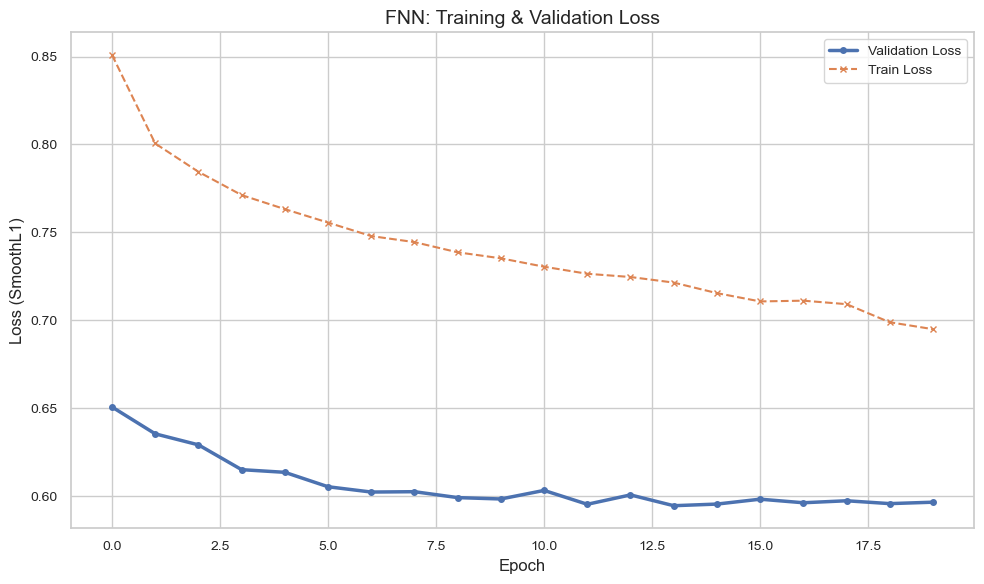

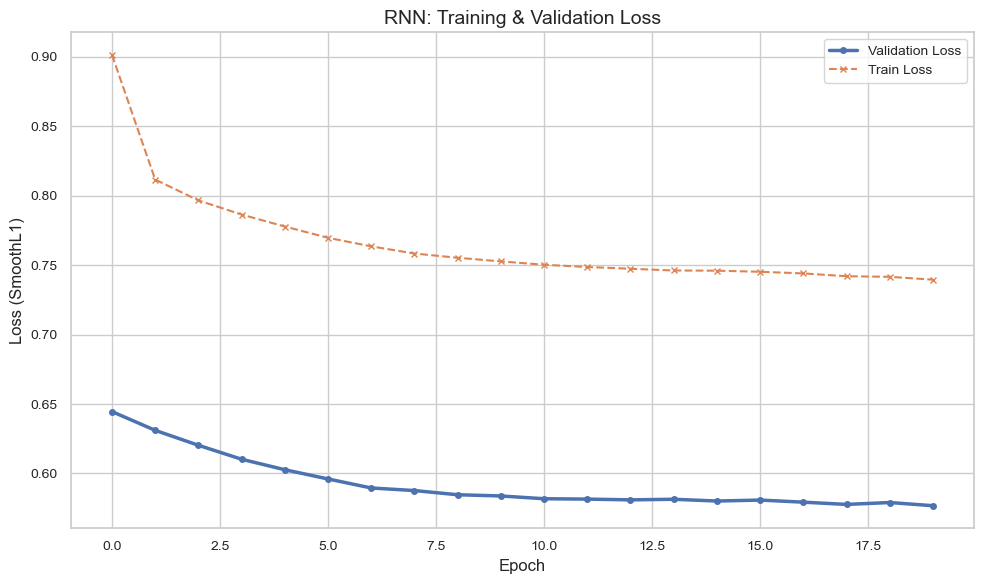

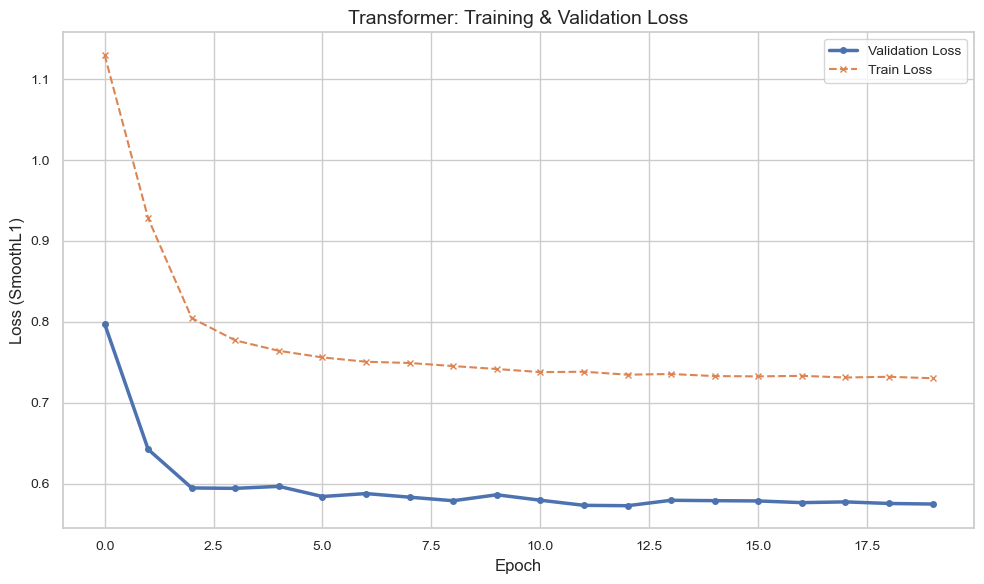

In [43]:
print("\n--- Visualizing Training and Validation Curves (Individual Plots) ---")
sns.set_theme(style="whitegrid")

if not csv_log_paths:
    print("No log paths found to plot.")
else:
    for model_name, log_path in csv_log_paths.items():

        # Create a new figure for each model INSIDE the loop
        plt.figure(figsize=(10, 6)) 
        
        try:
            metrics_df = pd.read_csv(log_path) # Load metrics for the CURRENT model
        

            plot_title = f"{model_name}: Training & Validation Loss"
            

            # Validation Loss
            if "epoch" in metrics_df.columns and "val_loss" in metrics_df.columns:

                val_data_current_model = metrics_df.dropna(subset=["epoch", "val_loss"])
                val_data_current_model = val_data_current_model.sort_values(by="epoch")
                
                plt.plot(val_data_current_model["epoch"], val_data_current_model["val_loss"], 
                             label=f"Validation Loss", linewidth=2.5, marker="o", markersize=4)
            
            else:
                print(f"Warning: 'val_loss' or 'epoch' not found for {model_name} in {log_path}")



            # Training Loss
            if "train_loss" and "epoch" in metrics_df.columns:

                train_data_current_model = metrics_df.dropna(subset=["epoch", "train_loss"])
                train_data_current_model = train_data_current_model.sort_values(by="epoch")
                
                plt.plot(train_data_current_model["epoch"], train_data_current_model["train_loss"], 
                             label=f"Train Loss", linestyle="--", marker="x", markersize=4)
                
            else:
                print(f"Warning: Could not determine epoch-level training loss column for {model_name} in {log_path}")

            # Only show plot if something was actually plotted
            
            plt.xlabel("Epoch", fontsize=12)
            plt.ylabel("Loss (SmoothL1)", fontsize=12)
            plt.title(plot_title, fontsize=14)
            plt.legend(fontsize=10)
            plt.xticks(fontsize=10)
            plt.yticks(fontsize=10)
            plt.tight_layout()
            plt.show() # Show plot for current model



        except Exception as e:
            print(f"Error processing/plotting log for {model_name} from {log_path}: {e}")


## Fundamental Difficulty of FPL Prediction:
FPL is notoriously hard to predict with high accuracy due to inherent randomness, injuries, sudden form changes, tactical shifts, etc. It's possible that with the current set of publicly available features, there's a natural limit to how well any model can perform, and your models are all hitting that limit quickly.

All models might be quickly learning the "easy" part of the prediction (e.g., most players score 0-2 points).
Beyond that, if the features you've engineered don't contain strong, consistent signals to differentiate between, say, a 2-point game and a 6-point game for the validation set, then no model, regardless of its complexity, will be able to make that distinction reliably on unseen data. They all hit the same "information ceiling."


Also good accuracy for players that score 0-2 points, however what about good players?

In [44]:
#Mohammed Salah prediction